### Recurrent Neural Networks

Here we return to our original sequence of historical load data without pivot
the prior hours' data into features as was needed with the regression
techniques.

Moreover, we will not immediately employ the walkforward validation technique due to the time cost of daily retraining. Instead we will train the model to always predict 24 hours out. This simplifies our train/validation/test split as well.

#### TODO predict 1 to 24 hours out

We should train seperate models that predict each of the subsequent 24 hours. These 24 models can be trained independently of each other. This would allow us to train on data that is more recent in the sequence. The hour-ending 24 model will still be trained as above, but the other hours will have a smaller `delay`... but we need the hourly prediction for a particular hour... this approach would just give a "good at `n` hours out" model across the entire day. We could train 1-hour-out models, then do walk forward validation as before...feeding the hourly prediction into the sequence 

In [2]:
%load_ext autoreload
%autoreload 2

from datasets import DataSet

ds = DataSet('data/zone1.parquet', mtlf='LRZ1 MTLF (MWh)', actual='LRZ1 ActualLoad (MWh)')
ds.data.head()

,MSP,DayOfYear,HourEnding,IsBusinessHour,LRZ1 MTLF (MWh),LRZ1 ActualLoad (MWh)
hour,,,,,,
2015-02-01 00:00:00-05:00,23.00,32,1,0,11099,11337.89
2015-02-01 01:00:00-05:00,21.02,32,2,0,10829,11014.87
2015-02-01 02:00:00-05:00,19.04,32,3,0,10565,10795.37
2015-02-01 03:00:00-05:00,19.04,32,4,0,10468,10714.42
2015-02-01 04:00:00-05:00,17.06,32,5,0,10432,10700.09


Since we are predicting 24 hours out, it is acceptable to incorporate the temperature data again, but we will need to normalize. We also will drop our categoricals for now. Can an RNN learn a good model for predicting tomorrow's load from just prior load and temperature sequences? Should we incorporate more temperature sequences?

In [4]:
features = ['MSP', 'DayOfYear', 'HourEnding', 'IsBusinessHour', ds.actual]
df = ds.data[features].copy()
df[ds.actual] = df[ds.actual] / 100
raw_data = df.to_numpy()
load = ds.data[ds.actual].to_numpy()

# 50/25/25 split. Probably need a different approach to validate over a year.
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
#raw_data /= std

In [5]:
import numpy as np
from validation import walkforward, Error
from tensorflow import keras

# our input sequence will be seven days of hourly observations
sampling_rate = 1
sequence_length = 72 #24*7

# delay to ensure our predictions don't use intraday information
# we start with 24 hours out
delay = sampling_rate * (sequence_length + 24 - 1) 

batch_size = 32 # hyperparameter
should_shuffle = True

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=load[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=should_shuffle,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=load[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=should_shuffle,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=load[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=should_shuffle,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples
)

In [6]:
def evaluate(model, epochs=10):
    callbacks = [keras.callbacks.ModelCheckpoint("naive_lstm.keras", save_best_only=True)]
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks)
    model = keras.models.load_model("naive_lstm.keras")
    print(f"Test MAE: {model.evaluate(test_dataset)[1]:2f}")
    return history

from tensorflow.keras import layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

In [8]:
x = layers.LSTM(64, unroll=True, return_sequences=True)(inputs)
x = layers.LSTM(64, unroll=True)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
history = evaluate(model, epochs=50)

Epoch 1/50
979/979 [==============================] - 33s 23ms/step - loss: 125178136.0000 - mae: 11064.9092 - val_loss: 120327040.0000 - val_mae: 10854.8896
Epoch 2/50
979/979 [==============================] - 21s 21ms/step - loss: 123751704.0000 - mae: 11000.2578 - val_loss: 118947848.0000 - val_mae: 10791.1748
Epoch 3/50
979/979 [==============================] - 21s 21ms/step - loss: 122357720.0000 - mae: 10936.7275 - val_loss: 117582912.0000 - val_mae: 10727.7461
Epoch 4/50
979/979 [==============================] - 21s 21ms/step - loss: 120975888.0000 - mae: 10873.3623 - val_loss: 116228528.0000 - val_mae: 10664.4346
Epoch 5/50
979/979 [==============================] - 21s 21ms/step - loss: 119603536.0000 - mae: 10810.0635 - val_loss: 114883072.0000 - val_mae: 10601.1602
Epoch 6/50
979/979 [==============================] - 21s 21ms/step - loss: 118239776.0000 - mae: 10746.8164 - val_loss: 113546016.0000 - val_mae: 10537.9121
Epoch 7/50
979/979 [==============================] 

In [9]:
def continue_evaluate(epochs=10):
    model = keras.models.load_model("naive_lstm.keras")
    callbacks = [keras.callbacks.ModelCheckpoint("naive_lstm.keras", save_best_only=True)]
    history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks)
    model = keras.models.load_model("naive_lstm.keras")
    print(f"Test MAE: {model.evaluate(test_dataset)[1]:2f}")
    return history

In [11]:
two_layer_history_2 = continue_evaluate(epochs=100)

Epoch 1/100
979/979 [==============================] - 39s 33ms/step - loss: 65224796.0000 - mae: 7904.3657 - val_loss: 61719864.0000 - val_mae: 7695.5508
Epoch 2/100
979/979 [==============================] - 30s 30ms/step - loss: 64231476.0000 - mae: 7841.2803 - val_loss: 60752904.0000 - val_mae: 7632.4707
Epoch 3/100
979/979 [==============================] - 29s 30ms/step - loss: 63246340.0000 - mae: 7778.2046 - val_loss: 59794132.0000 - val_mae: 7569.3994
Epoch 4/100
979/979 [==============================] - 29s 29ms/step - loss: 62269196.0000 - mae: 7715.1431 - val_loss: 58843388.0000 - val_mae: 7506.3389
Epoch 5/100
979/979 [==============================] - 28s 29ms/step - loss: 61300148.0000 - mae: 7652.0806 - val_loss: 57900648.0000 - val_mae: 7443.2739
Epoch 6/100
979/979 [==============================] - 28s 29ms/step - loss: 60338960.0000 - mae: 7589.0195 - val_loss: 56965872.0000 - val_mae: 7380.2100
Epoch 7/100
979/979 [==============================] - 29s 29ms/step -

In [100]:

history5 = continue_evaluate(epochs=50)

Epoch 1/50
979/979 [==============================] - 35s 32ms/step - loss: 2762329.2500 - mae: 1324.8834 - val_loss: 2501932.2500 - val_mae: 1289.6077
Epoch 2/50
979/979 [==============================] - 29s 30ms/step - loss: 2756923.5000 - mae: 1323.9449 - val_loss: 2504910.7500 - val_mae: 1290.4341
Epoch 3/50
979/979 [==============================] - 30s 31ms/step - loss: 2753159.5000 - mae: 1323.3875 - val_loss: 2508093.5000 - val_mae: 1291.3124
Epoch 4/50
979/979 [==============================] - 29s 30ms/step - loss: 2750556.7500 - mae: 1323.0702 - val_loss: 2511313.2500 - val_mae: 1292.1757
Epoch 5/50
979/979 [==============================] - 30s 31ms/step - loss: 2748801.2500 - mae: 1322.9232 - val_loss: 2514267.0000 - val_mae: 1292.9673
Epoch 6/50
979/979 [==============================] - 29s 30ms/step - loss: 2747653.0000 - mae: 1322.8746 - val_loss: 2516886.2500 - val_mae: 1293.6660
Epoch 7/50
979/979 [==============================] - 30s 30ms/step - loss: 2746924.0000

In [ ]:

history4 = continue_evaluate(epochs=50)

Epoch 1/50
979/979 [==============================] - 35s 32ms/step - loss: 5589729.5000 - mae: 1913.5093 - val_loss: 4685331.5000 - val_mae: 1764.5638
Epoch 2/50
979/979 [==============================] - 30s 30ms/step - loss: 5389443.5000 - mae: 1874.1122 - val_loss: 4510378.0000 - val_mae: 1728.2250
Epoch 3/50
979/979 [==============================] - 31s 31ms/step - loss: 5196894.0000 - mae: 1836.0043 - val_loss: 4342994.0000 - val_mae: 1693.0957
Epoch 4/50
979/979 [==============================] - 30s 30ms/step - loss: 5012089.0000 - mae: 1799.1465 - val_loss: 4183333.2500 - val_mae: 1659.2870
Epoch 5/50
979/979 [==============================] - 31s 31ms/step - loss: 4834981.5000 - mae: 1763.7004 - val_loss: 4031318.7500 - val_mae: 1626.9216
Epoch 6/50
979/979 [==============================] - 30s 30ms/step - loss: 4665585.0000 - mae: 1729.6680 - val_loss: 3887001.2500 - val_mae: 1596.0016
Epoch 7/50
979/979 [==============================] - 31s 31ms/step - loss: 4503937.5000

In [7]:
x = layers.LSTM(64, unroll=True)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
history = evaluate(model, epochs=50)

Epoch 1/50
979/979 [==============================] - 16s 11ms/step - loss: 125128024.0000 - mae: 11062.6602 - val_loss: 120187896.0000 - val_mae: 10848.4775
Epoch 2/50
979/979 [==============================] - 10s 10ms/step - loss: 123594264.0000 - mae: 10993.1123 - val_loss: 118783904.0000 - val_mae: 10783.5723
Epoch 3/50
979/979 [==============================] - 10s 10ms/step - loss: 122186568.0000 - mae: 10928.8926 - val_loss: 117412752.0000 - val_mae: 10719.8105
Epoch 4/50
979/979 [==============================] - 10s 10ms/step - loss: 120800992.0000 - mae: 10865.3242 - val_loss: 116056760.0000 - val_mae: 10656.3760
Epoch 5/50
979/979 [==============================] - 10s 10ms/step - loss: 119428024.0000 - mae: 10801.9619 - val_loss: 114711528.0000 - val_mae: 10593.0635
Epoch 6/50
979/979 [==============================] - 10s 10ms/step - loss: 118064688.0000 - mae: 10738.6689 - val_loss: 113375200.0000 - val_mae: 10529.8086
Epoch 7/50
979/979 [==============================] 

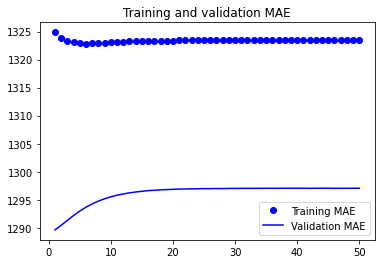

In [101]:
import matplotlib.pyplot as plt
loss = history5.history["mae"]
val_loss = history5.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

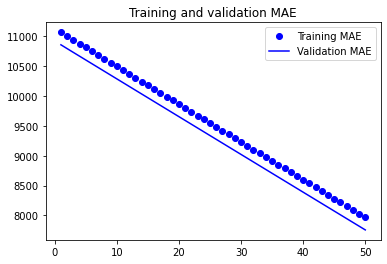

In [10]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [61]:
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(inputs)
x = layers.LSTM(32)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
evaluate(model)

Epoch 1/10
123/123 [==============================] - 17s 119ms/step - loss: 125989480.0000 - mae: 11101.4648 - val_loss: 121780832.0000 - val_mae: 10921.6025
Epoch 2/10
123/123 [==============================] - 14s 117ms/step - loss: 125881392.0000 - mae: 11096.5947 - val_loss: 121692072.0000 - val_mae: 10917.5371
Epoch 3/10
123/123 [==============================] - 14s 117ms/step - loss: 125791344.0000 - mae: 11092.5342 - val_loss: 121603464.0000 - val_mae: 10913.4795
Epoch 4/10
123/123 [==============================] - 14s 117ms/step - loss: 125701304.0000 - mae: 11088.4717 - val_loss: 121514880.0000 - val_mae: 10909.4238
Epoch 5/10
123/123 [==============================] - 14s 117ms/step - loss: 125611320.0000 - mae: 11084.4209 - val_loss: 121426344.0000 - val_mae: 10905.3604
Epoch 6/10
123/123 [==============================] - 14s 117ms/step - loss: 125521328.0000 - mae: 11080.3555 - val_loss: 121337840.0000 - val_mae: 10901.3057
Epoch 7/10
123/123 [==========================

In [ ]:
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(inputs)
x = layers.LSTM(32)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
evaluate(model)

Epoch 1/10
123/123 [==============================] - 17s 119ms/step - loss: 125989480.0000 - mae: 11101.4648 - val_loss: 121780832.0000 - val_mae: 10921.6025
Epoch 2/10
123/123 [==============================] - 14s 117ms/step - loss: 125881392.0000 - mae: 11096.5947 - val_loss: 121692072.0000 - val_mae: 10917.5371
Epoch 3/10
123/123 [==============================] - 14s 117ms/step - loss: 125791344.0000 - mae: 11092.5342 - val_loss: 121603464.0000 - val_mae: 10913.4795
Epoch 4/10
123/123 [==============================] - 14s 117ms/step - loss: 125701304.0000 - mae: 11088.4717 - val_loss: 121514880.0000 - val_mae: 10909.4238
Epoch 5/10
123/123 [==============================] - 14s 117ms/step - loss: 125611320.0000 - mae: 11084.4209 - val_loss: 121426344.0000 - val_mae: 10905.3604
Epoch 6/10
123/123 [==============================] - 14s 117ms/step - loss: 125521328.0000 - mae: 11080.3555 - val_loss: 121337840.0000 - val_mae: 10901.3057
Epoch 7/10
123/123 [==========================

In [60]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, return_sequences=True)(inputs)
x = layers.LSTM(64, return_sequences=True)(inputs)
x = layers.LSTM(32)(inputs)
#x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
#x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
evaluate(model)

Epoch 1/10
123/123 [==============================] - 4s 29ms/step - loss: 126039144.0000 - mae: 11103.6895 - val_loss: 121801320.0000 - val_mae: 10922.5420
Epoch 2/10
123/123 [==============================] - 3s 28ms/step - loss: 125897816.0000 - mae: 11097.3350 - val_loss: 121706424.0000 - val_mae: 10918.1963
Epoch 3/10
123/123 [==============================] - 3s 28ms/step - loss: 125805664.0000 - mae: 11093.1807 - val_loss: 121617432.0000 - val_mae: 10914.1221
Epoch 4/10
123/123 [==============================] - 3s 28ms/step - loss: 125715456.0000 - mae: 11089.1152 - val_loss: 121528840.0000 - val_mae: 10910.0596
Epoch 5/10
123/123 [==============================] - 3s 28ms/step - loss: 125625504.0000 - mae: 11085.0566 - val_loss: 121440312.0000 - val_mae: 10906.0029
Epoch 6/10
123/123 [==============================] - 3s 28ms/step - loss: 125535544.0000 - mae: 11081.0029 - val_loss: 121351784.0000 - val_mae: 10901.9453
Epoch 7/10
123/123 [==============================] - 3s 2